In [33]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import pymc as pm
import numpy as np
from constants import stablecoins

### Load Data

In [34]:
df = pd.read_csv("all_coins_data.csv")

In [35]:
#df = read_data("all_coins_data.csv")
nodes = list(set(df.coin))#Get unique list of coins
volatile_coins = [n for n in nodes if nodes not in stablecoins]
df["stablecoin"] = [1 if c in stablecoins else 0 for c in df["coin"]]
df.to_csv("df_app_data.csv", sep=";", index = False)
df.head()

,time,high,low,open,volumefrom,volumeto,close,conversion_type,conversion_symbol,coin,daily_return_pct,intraday_return,daily_log_return,stablecoin
0,2020-08-22,0.1262,0.1183,0.1229,84207229.64,10373929.94,0.1253,direct,NaN,ADA,0.019528,0.019528,0.019340,0
1,2020-08-23,0.1259,0.1195,0.1253,64772529.12,7945897.18,0.1215,direct,NaN,ADA,-0.030327,-0.030327,-0.030797,0
2,2020-08-24,0.1270,0.1201,0.1215,77809944.45,9662533.63,0.1237,direct,NaN,ADA,0.018107,0.018107,0.017945,0
3,2020-08-25,0.1238,0.1063,0.1237,65939158.71,7699604.99,0.1126,direct,NaN,ADA,-0.089733,-0.089733,-0.094018,0
4,2020-08-26,0.1183,0.1107,0.1126,21686624.36,2483949.36,0.1144,direct,NaN,ADA,0.015986,0.015986,0.015859,0


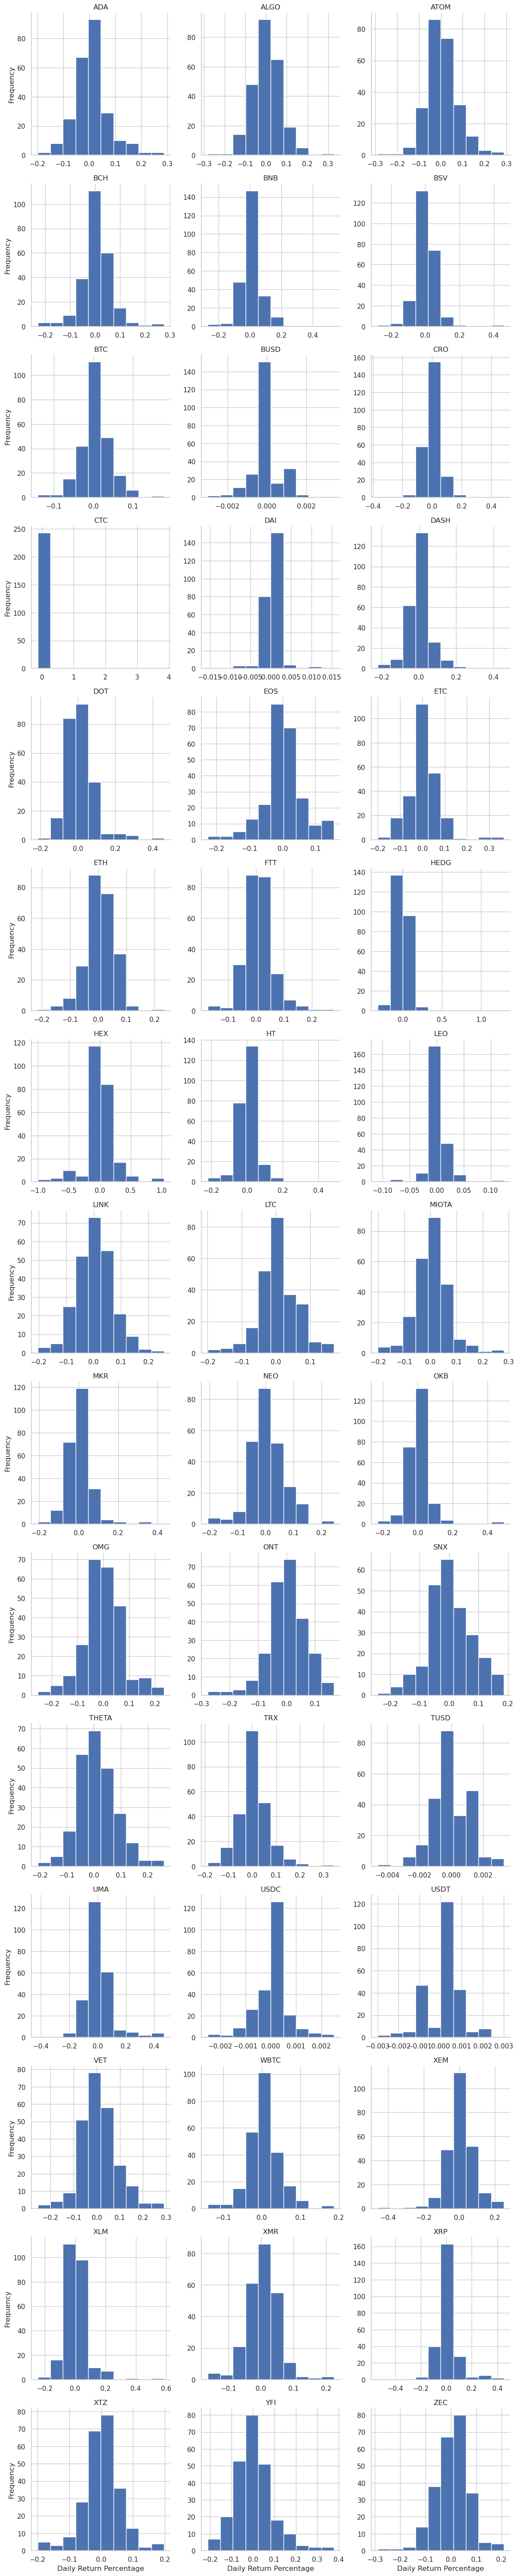

In [36]:
colors = [
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF",
    "#00FFFF", "#FF4500", "#8A2BE2", "#32CD32", "#FFD700",
    "#A0522D", "#008080", "#800080", "#2E8B57", "#00CED1",
    "#FF6347", "#40E0D0", "#8B4513", "#6A5ACD", "#7FFF00",
    "#DA70D6", "#228B22", "#D2691E", "#4682B4", "#556B2F",
    "#8B008B", "#8B0000", "#9400D3", "#7B68EE", "#6B8E23",
    "#20B2AA", "#DC143C", "#FF8C00", "#BDB76B", "#8B4513",
    "#FF1493", "#9932CC", "#F0E68C", "#00FF7F", "#9370DB",
    "#48D1CC", "#2F4F4F", "#FF69B4", "#8B0000", "#4B0082"
]

# Set the style for seaborn
sns.set(style="whitegrid")

# Create small multiple histograms
g = sns.FacetGrid(df, col="coin", col_wrap=3, height=4, sharey=False, sharex = False)
g.map(plt.hist, 'daily_log_return')#, bins=50)

# Add labels and title
g.set_axis_labels("Daily Return Percentage", "Frequency")
g.set_titles(col_template="{col_name}")

# Show the plot
plt.show()

In [51]:
stock_returns = df[["time", "coin","close"]].pivot(index = "time",columns = "coin", values = "close").pct_change().dropna().reset_index().melt(id_vars = "time")
stock_returns

,time,coin,value
0,2020-08-23,ADA,-0.030327
1,2020-08-24,ADA,0.018107
2,2020-08-25,ADA,-0.089733
3,2020-08-26,ADA,0.015986
4,2020-08-27,ADA,-0.062063
...,...,...,...
11020,2021-04-20,ZEC,0.106713
11021,2021-04-21,ZEC,-0.049612
11022,2021-04-22,ZEC,-0.055948
11023,2021-04-23,ZEC,-0.014760


### Bayesian model

In [57]:
import pymc as pm

with pm.Model() as model: 
    returns = pm.Data("returns", stock_returns["value"], dims = ["coin"], export_index_as_coords=True)
    nu  = pm.Exponential("nu", 0.1, testval = 5)

    sigma = pm.Exponential("sigma", 50, testval = 0.1)

    s = pm.GaussianRandomWalk("s", sigma = sigma, dims=["coin"])
    volatility_process = pm.Deterministic("volatility", pm.math.exp(-2*s)**0.5, dims=["coin"])

    r = pm.StudentT("r", nu = nu, sigma = volatility_process, observed= returns, dims = "coin")

    trace = pm.sample()

/home/fede/anaconda3/envs/pymc/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
/tmp/ipykernel_581957/4223752297.py:5: FutureWarning: The `testval` argument is deprecated; use `initval`.
  nu  = pm.Exponential("nu", 0.1, testval = 5)
/tmp/ipykernel_581957/4223752297.py:7: FutureWarning: The `testval` argument is deprecated; use `initval`.
  sigma = pm.Exponential("sigma", 50, testval = 0.1)
/home/fede/anaconda3/envs/pymc/lib/python3.11/site-packages/pymc/distributions/timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this 

In [ ]:
pm.traceplot(trace)